# Dimensionality Reduction


* This worksheet is specially created to experiment with dimensionality reduction in the `MNIST` dataset and to work on 2 exercise questions from the corresponding chapter of `Hands on ML` book. 

## Import Libraries

In [2]:
from sklearn.preprocessing import Binarizer, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from pathlib import Path
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import json
import gdown
import os
import sys
import tqdm
import time
import warnings
from huggingface_hub import login, HfApi,list_repo_files, hf_hub_download
import os
import sys
import dotenv
from pathlib import Path
import tqdm

## Read Data

In [3]:
notebook_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(notebook_dir , "mnist_digits_recognition"))  

model_root = os.path.join(project_root, "models")
model_dir = project_root + '/models/ensemble/'
data_root = os.path.join(project_root, "data")

In [4]:
raw_data = pd.read_csv(data_root + '/raw_mnist_data.csv')

In [5]:
raw_data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [6]:
raw_data.shape

(70000, 785)

## Exercise 1
* Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). 
* Train a random forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. 
* Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. 
* Train a new random forest classifier on the reduced dataset and see how long it takes. 
* Was training much faster? Next, evaluate the classifier on the test set. How does it compare to the previous classifier? Try again with an SGDClassifier. How much does PCA help now?


### Train Test Split

In [7]:
## train test split
from sklearn.model_selection import train_test_split


X = raw_data.drop(columns=['class'])
y = raw_data['class']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=10000, random_state=42)


In [8]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((60000, 784), (10000, 784), (60000,), (10000,))

### Random Forest Classifier

#### Without Dimensionality Reduction

In [9]:
## train random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

start = time.time()
rfc.fit(train_X, train_y)
end = time.time()
print(f'Time taken to train the model without dimensionality reduction: {end - start} seconds')

Time taken to train the model without dimensionality reduction: 35.79781103134155 seconds


#### Dimensionality Reduction with PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42, svd_solver='full')

start = time.time()
X_train_pca = pca.fit_transform(train_X)
X_test_pca = pca.transform(test_X)
end = time.time()
print(f'Time taken to transform the data: {end - start} seconds')
print(f'Original shape: {train_X.shape}')
print(f'Transformed shape: {X_train_pca.shape}')
print(f'Percent reduction in dimensionality: {100 * (1 - X_train_pca.shape[1] / train_X.shape[1]):.2f}%')

Time taken to transform the data: 2.5827884674072266 seconds
Original shape: (60000, 784)
Transformed shape: (60000, 154)
Percent reduction in dimensionality: 80.36%


Observation:
* So we reduced ~80% of dimensions and we still have 95% of variance. This should significanly increase the training speed. 

In [11]:
## train random forest classifier with PCA
rfc_pca = RandomForestClassifier(n_estimators=100, random_state=42)
start = time.time()
rfc_pca.fit(X_train_pca, train_y)
end = time.time()
print(f'Time taken to train the model with dimensionality reduction: {end - start} seconds')


Time taken to train the model with dimensionality reduction: 94.6279547214508 seconds


Observations:
* Interesting! I thought that reducing dimensions would improve the training time, but it got slower, almost 3 times slower.

In [27]:
## lets compare the non zero values in pca and the original data
pca_non_zero_values = np.count_nonzero(X_train_pca)
original_non_zero_values = np.count_nonzero(train_X)
print(f'Non zero values in PCA transformed data: {pca_non_zero_values}')
print(f'Non zero values in original data: {original_non_zero_values}')
print(f'Percent non zero values in PCA transformed data: {100 * (pca_non_zero_values / original_non_zero_values):.2f}%')


Non zero values in PCA transformed data: 9240000
Non zero values in original data: 9010019
Percent non zero values in PCA transformed data: 102.55%


* On doing some research I found that there one of the reason that for this counter intuitive behavior would be,
    * PCA converts sparse dataset into a dense dataset with more floating point nubmers. This could slow down finding the best node which involves evaluating potential thresholds on the feature values. 

#### Comparing Performances

In [12]:
## lets compare the performance of the two models
from sklearn.metrics import classification_report

y_pred = rfc.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
weighted_f1 = f1_score(test_y, y_pred, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores = f1_score(test_y, y_pred, average=None)
per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}

print("Performance without PCA:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Weighted F1 score: {weighted_f1:.4f}')
# print('Per-class F1 scores:')
# for class_label, score in per_class_f1_dict.items():
#     print(f'{class_label}: {score:.4f}')

## post pca 
y_pred_pca = rfc_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(test_y, y_pred_pca)
weighted_f1_pca = f1_score(test_y, y_pred_pca, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores_pca = f1_score(test_y, y_pred_pca, average=None)
per_class_f1_dict_pca = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores_pca)}
print("Performance with PCA:")
print(f'Accuracy: {accuracy_pca:.4f}')
print(f'Weighted F1 score: {weighted_f1_pca:.4f}')
# print('Per-class F1 scores:')
# for class_label, score in per_class_f1_dict_pca.items():
#     print(f'{class_label}: {score:.4f}')


Performance without PCA:
Accuracy: 0.9674
Weighted F1 score: 0.9674
Performance with PCA:
Accuracy: 0.9487
Weighted F1 score: 0.9486


Observations:
* Both accuracy and weighted F1 score dropped by ~2% after applying PCA.
* This aligns with expectations, since PCA retained ~95% of the variance—meaning ~5% of the original information was discarded in the transformation.

### SGDClassifier

#### Without Dimensionality Reduction

In [13]:
from sklearn.linear_model import SGDClassifier


sgd = SGDClassifier(random_state=42)

start = time.time()
sgd.fit(train_X, train_y)
end = time.time()
print(f'Time taken to train the model without dimensionality reduction: {end - start} seconds')

Time taken to train the model without dimensionality reduction: 129.69086527824402 seconds


#### With Dimensionality Reduction

In [14]:
## sgd classifier with dimensionality reduction
sgd_pca = SGDClassifier(random_state=42)
start = time.time()
sgd_pca.fit(X_train_pca, train_y)
end = time.time()
print(f'Time taken to train the model with dimensionality reduction: {end - start} seconds')

Time taken to train the model with dimensionality reduction: 25.144052505493164 seconds


Observations:
* Very interesting I think I understand why it significanly improved training time here.
* Stochastic Gradient Descent (SGD) updates weights based on gradients computed for each feature dimension. So:
    * More features = more gradients to compute = more operations per step
	* Fewer features (via PCA) = fewer gradients to compute = faster updates per epoch


#### Comparing Performances

In [15]:
## lets compare the performance of the two models
y_pred_sgd = sgd.predict(test_X)
accuracy_sgd = accuracy_score(test_y, y_pred_sgd)
weighted_f1_sgd = f1_score(test_y, y_pred_sgd, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores_sgd = f1_score(test_y, y_pred_sgd, average=None)
per_class_f1_dict_sgd = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores_sgd)}
print("Performance without PCA:")
print(f'Accuracy: {accuracy_sgd:.4f}')
print(f'Weighted F1 score: {weighted_f1_sgd:.4f}')


## post pca
y_pred_sgd_pca = sgd_pca.predict(X_test_pca)
accuracy_sgd_pca = accuracy_score(test_y, y_pred_sgd_pca)
weighted_f1_sgd_pca = f1_score(test_y, y_pred_sgd_pca, average='weighted')
# Compute per-class F1 scores
per_class_f1_scores_sgd_pca = f1_score(test_y, y_pred_sgd_pca, average=None)
per_class_f1_dict_sgd_pca = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores_sgd_pca)}
print("Performance with PCA:")
print(f'Accuracy: {accuracy_sgd_pca:.4f}')
print(f'Weighted F1 score: {weighted_f1_sgd_pca:.4f}')


Performance without PCA:
Accuracy: 0.8691
Weighted F1 score: 0.8705
Performance with PCA:
Accuracy: 0.8907
Weighted F1 score: 0.8899


Observation:
* In this case the `Accuracy` and `Weighted F1 Score` has improved by ~3%. 
    * This is because for `SGD` PCA removes features which were unimportant and adding noise to the gradient descent.

## Exercise 2

* Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to 2 dimensions and plot the result using Matplotlib. 
* You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). 
* You should get a nice visualization with well-separated clusters of digits. 
* Try using other dimensionality reduction algorithms, such as PCA, LLE, or MDS, and compare the resulting visualizations.

In [30]:
## pick 5000 stratified samples from the training data
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, train_size=5000, random_state=42)
sss.get_n_splits(train_X, train_y)

for train_index, test_index in sss.split(train_X, train_y):
    stratified_train_X, stratified_test_X = train_X.iloc[train_index], train_X.iloc[test_index]
    stratified_train_y, stratified_test_y = train_y.iloc[train_index], train_y.iloc[test_index]
print(stratified_train_X.shape, stratified_test_X.shape)
print(stratified_train_y.shape, stratified_test_y.shape)

(5000, 784) (55000, 784)
(5000,) (55000,)


In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
start = time.time()
X_train_tsne = tsne.fit_transform(stratified_train_X)
end = time.time()
print(f'Time taken to transform the data: {end - start} seconds')
print(f'Original shape: {stratified_train_X.shape}')
print(f'Transformed shape: {X_train_tsne.shape}')


Time taken to transform the data: 31.684885263442993 seconds
Original shape: (5000, 784)
Transformed shape: (5000, 2)


In [52]:
## lets plot the data using seabourn

# plt.figure(figsize=(10, 10))
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=stratified_train_y, cmap='viridis', s=5)
# plt.colorbar()
# plt.title('t-SNE visualization of MNIST data')

# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(X_train_tsne, columns=['Component 1', 'Component 2'])
tsne_df['Label'] = stratified_train_y.values
# Plot using seaborn



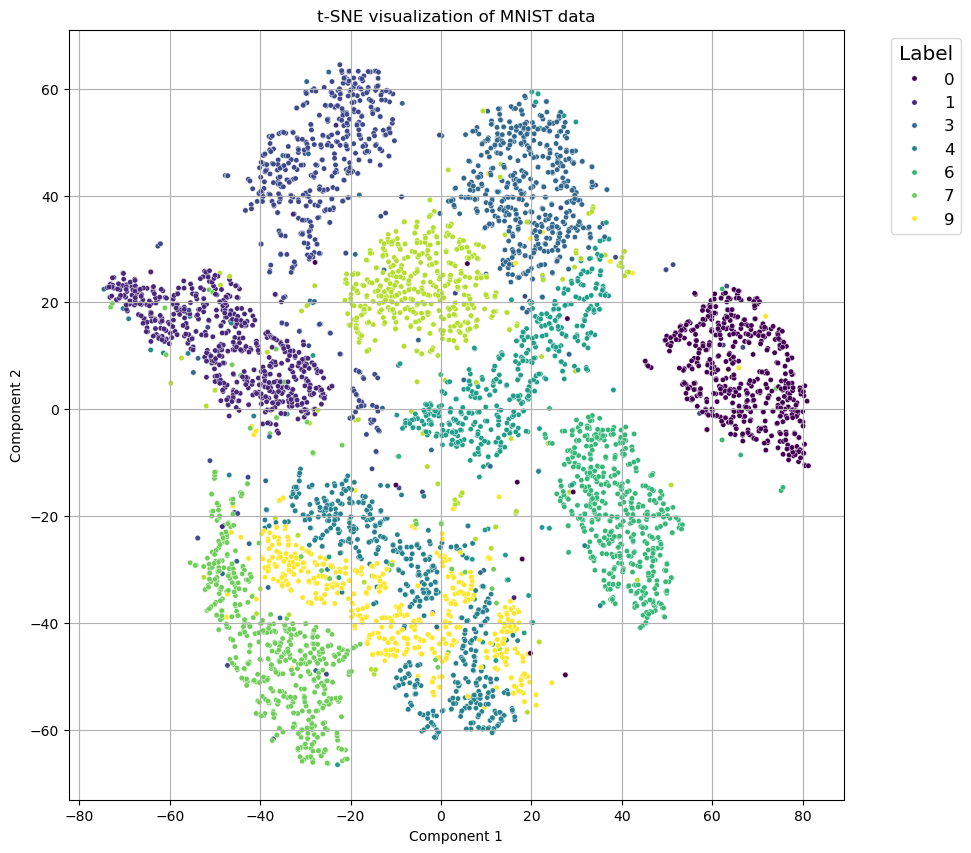

In [53]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=tsne_df, x='Component 1', y='Component 2', hue='Label', palette='viridis', s=15)
plt.title('t-SNE visualization of MNIST data')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='x-large')
plt.grid(True)
plt.show()

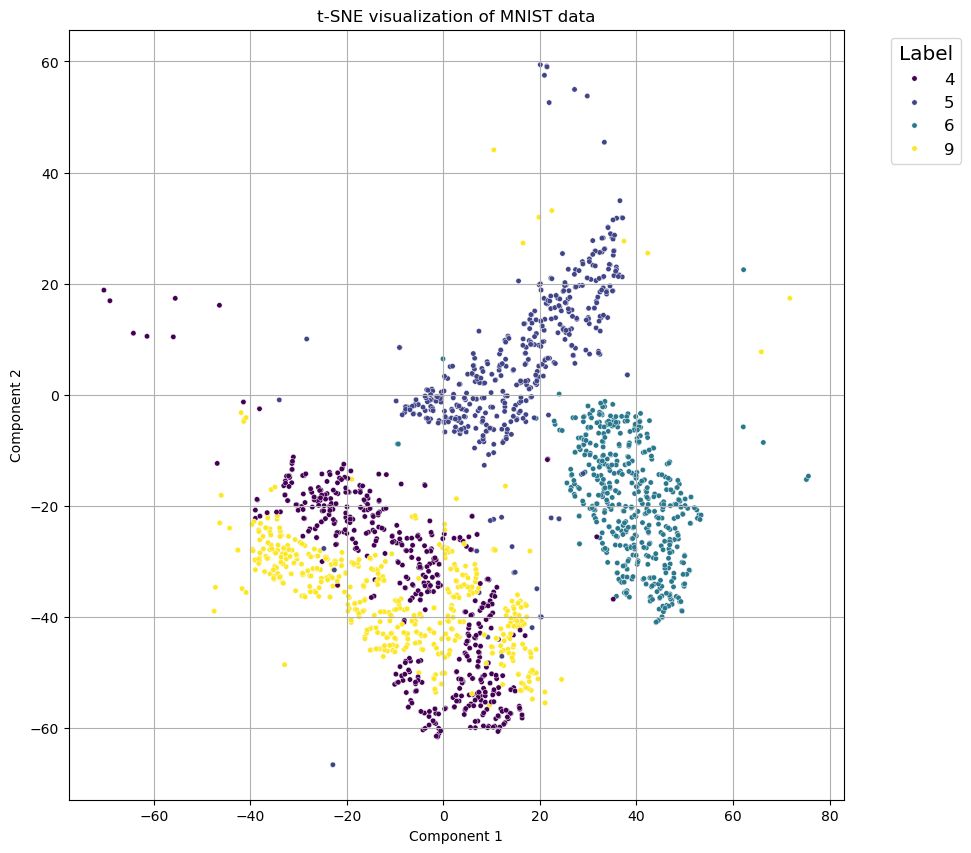

In [54]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=tsne_df[tsne_df['Label'].isin([4,5,6,9])], x='Component 1', y='Component 2', hue='Label', palette='viridis', s=15)
plt.title('t-SNE visualization of MNIST data')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='x-large')
plt.grid(True)
plt.show()

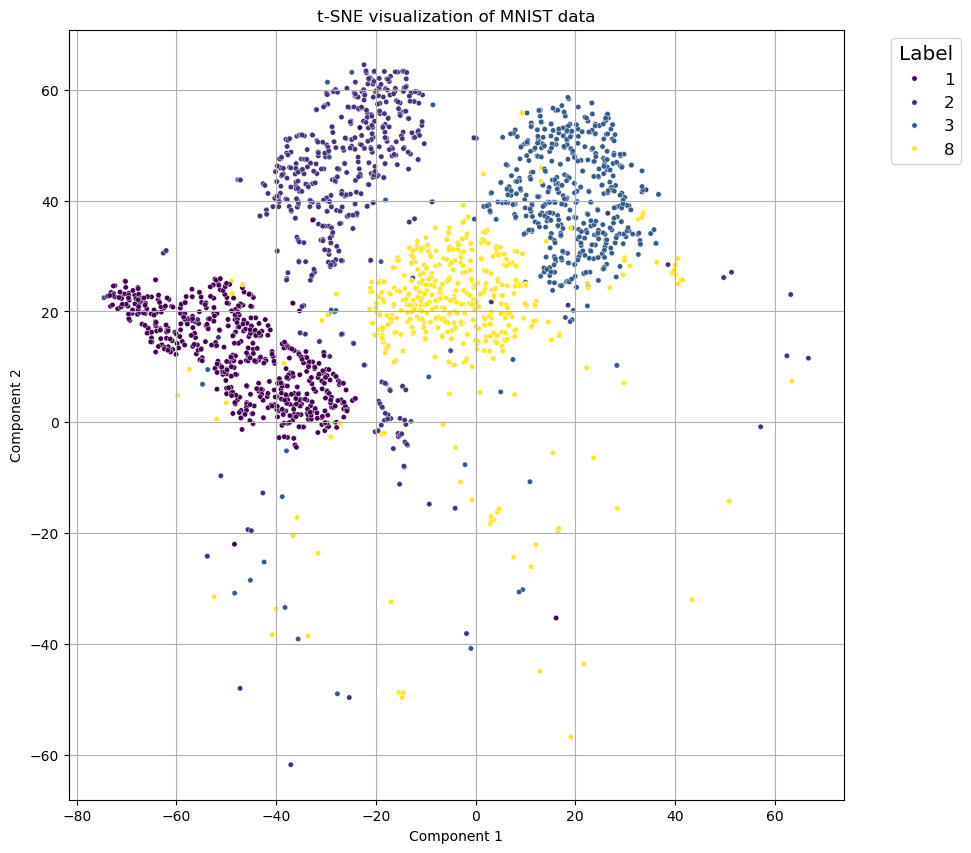

In [57]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=tsne_df[tsne_df['Label'].isin([1,2,3,8])], x='Component 1', y='Component 2', hue='Label', palette='viridis', s=15)
plt.title('t-SNE visualization of MNIST data')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='x-large')
plt.grid(True)
plt.show()

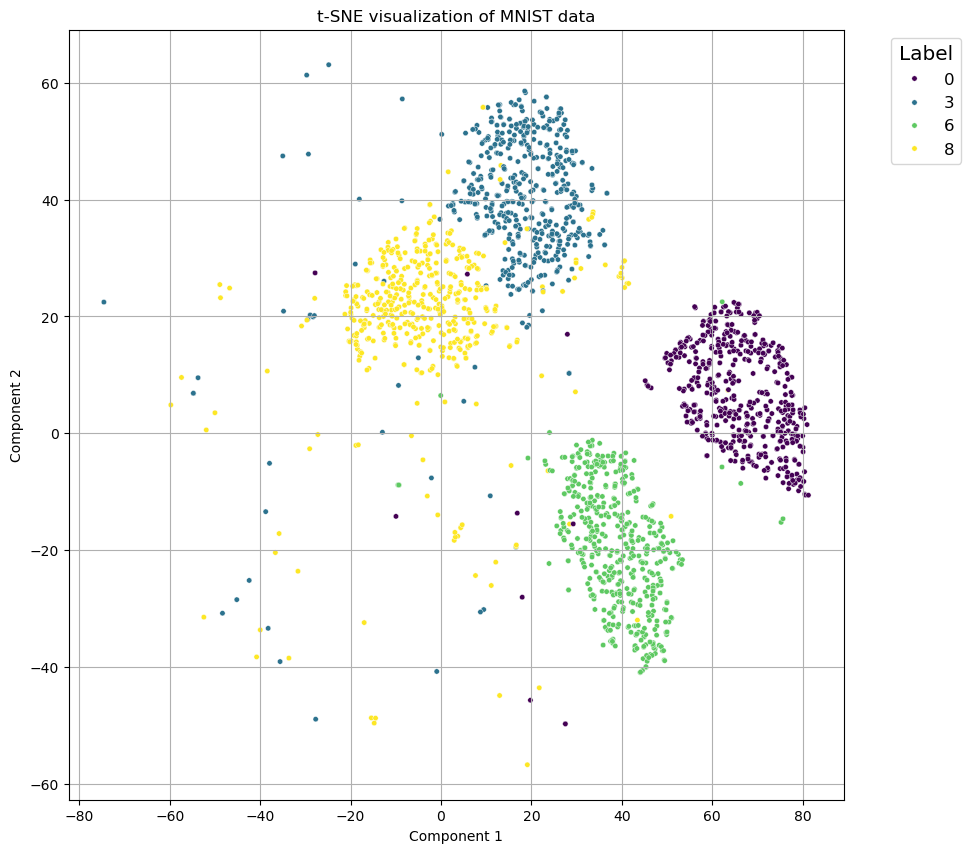

In [59]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=tsne_df[tsne_df['Label'].isin([0,3,6,8])], x='Component 1', y='Component 2', hue='Label', palette='viridis', s=15)
plt.title('t-SNE visualization of MNIST data')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='x-large')
plt.grid(True)
plt.show()

Observations:
* 4 and 9 has overlapping clusters which aligns with the confusion matrices we created during training. Handwritten 4 and 9 do have similar loop and step structures so makes sense the pixel clusers are overlapping. 
* Again similar observation in 2 and 8. Although the clusters are quite separate there is some overlapping there. 
* 1,2 and 7 are quite distinct and so are 0,6 and 8 which is surpricing to see. 